In [16]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import mscproject.pygloaders as pgl
from mscproject.metrics import EvalMetrics
import catboost as cb

In [17]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [18]:
# Load features for data split.
def load_features(path_root, split):
    features_dir = Path(path_root) / split if split else Path(path_root)
    companies_df = pd.read_parquet(features_dir / "companies.parquet").dropna()
    persons_df = pd.read_parquet(features_dir / "persons.parquet").dropna()
    return companies_df, persons_df

In [19]:
companies_df, persons_df = load_features(features_path, None)

In [20]:
select_cols = list(set(companies_df.columns) & set(persons_df.columns))
# processed_feature_cols = [x for x in select_cols if x.endswith("__processed")]
# raw_feature_cols = [x.split("__processed")[0] for x in processed_feature_cols]
target = "is_anomalous"

entities_df = pd.concat([companies_df, persons_df], axis=0)[select_cols]

drop_cols = ["id", "name", "component"]


In [21]:
masks = pgl.get_data_split_masks(entities_df)

In [22]:
train_df = entities_df.loc[list(masks.train.numpy())].drop(drop_cols, axis=1)
valid_df = entities_df.loc[list(masks.val.numpy())].drop(drop_cols, axis=1)
test_df = entities_df.loc[list(masks.test.numpy())].drop(drop_cols, axis=1)

In [23]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

valid_pool = cb.Pool(
    X_valid.to_numpy(),
    y_valid.to_numpy(),
    cat_features=cat_features,
    feature_names=X_valid.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [24]:
# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=2000,
    # learning_rate=0.1,
    depth=6,
    # eval_metric="Accuracy",
    random_seed=42,
)


# Fit model.
clf.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=200,
)

Learning rate set to 0.052796
0:	learn: 0.6390575	test: 0.6318519	best: 0.6318519 (0)	total: 2.78ms	remaining: 5.57s
200:	learn: 0.2266300	test: 0.1351969	best: 0.1351969 (200)	total: 515ms	remaining: 4.61s
400:	learn: 0.2123330	test: 0.1307962	best: 0.1307907 (399)	total: 1.02s	remaining: 4.09s
600:	learn: 0.2027698	test: 0.1296776	best: 0.1296776 (600)	total: 1.53s	remaining: 3.56s
800:	learn: 0.1953086	test: 0.1287792	best: 0.1287590 (796)	total: 2.03s	remaining: 3.04s
1000:	learn: 0.1886866	test: 0.1280715	best: 0.1280096 (972)	total: 2.52s	remaining: 2.52s
1200:	learn: 0.1831142	test: 0.1280692	best: 0.1278314 (1107)	total: 3.02s	remaining: 2.01s
1400:	learn: 0.1781135	test: 0.1277399	best: 0.1276370 (1355)	total: 3.52s	remaining: 1.51s
1600:	learn: 0.1734462	test: 0.1274597	best: 0.1274360 (1598)	total: 4.01s	remaining: 999ms
1800:	learn: 0.1695641	test: 0.1274349	best: 0.1271251 (1668)	total: 4.51s	remaining: 498ms
1999:	learn: 0.1657122	test: 0.1274701	best: 0.1271251 (1668)	to

In [25]:
# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

Predicted  False  True
Actual                
False       1814     5
True          52    82


In [26]:
# Evaluate model.
y_test_pred = np.array([x[1] for x in clf.predict_proba(test_pool)])
eval_metrics = EvalMetrics.from_numpy(y_test_pred, y_test.astype(int).to_numpy())
print(eval_metrics)

loss: 0.1284, accuracy: 0.9314, precision: 0.9425, recall: 0.6119, f1: 0.7421, auroc: 0.8860, average_precision: 0.7305


In [27]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

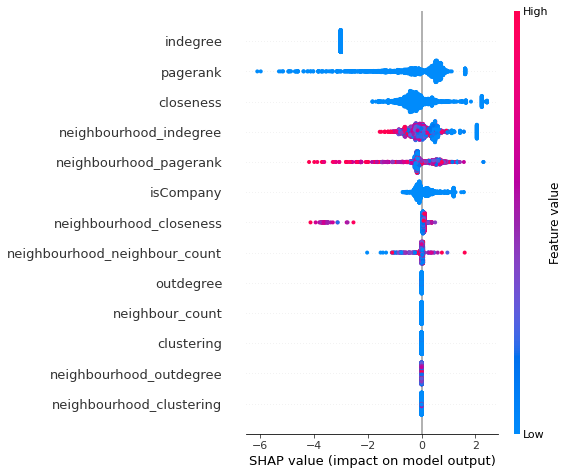

In [28]:
shap.summary_plot(shap_values, X_test)

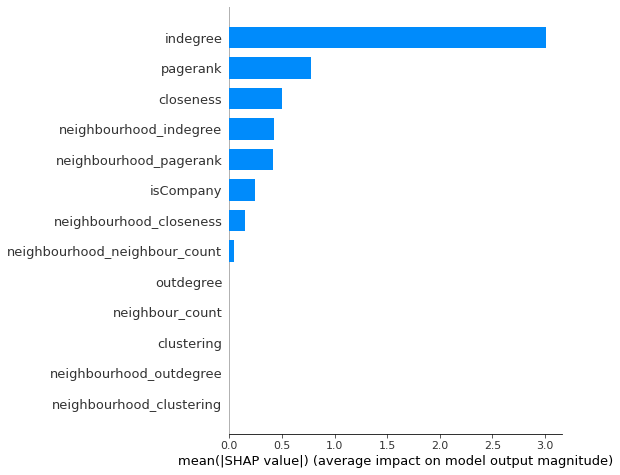

In [29]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

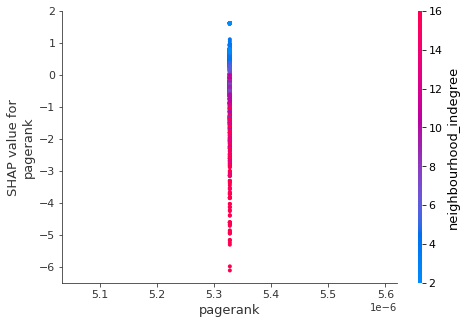

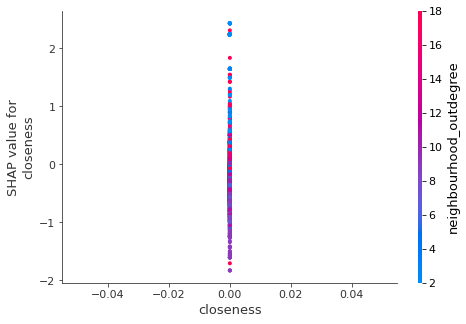

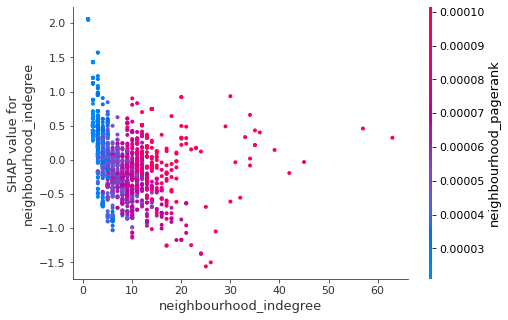

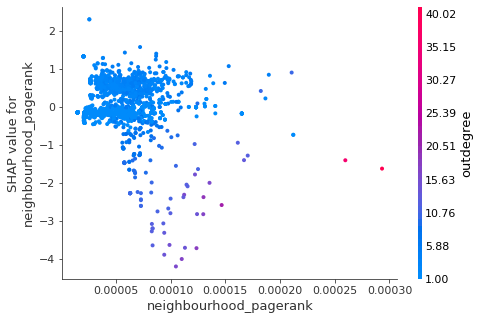

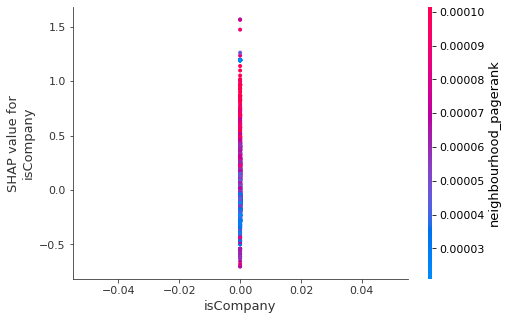

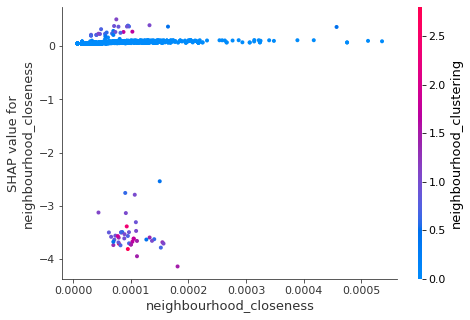

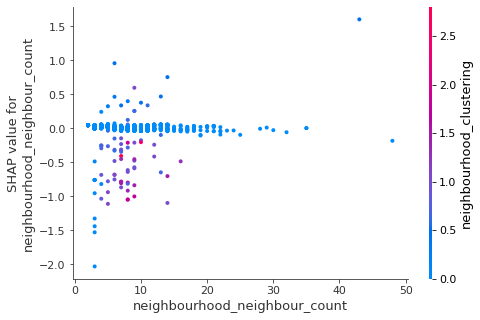

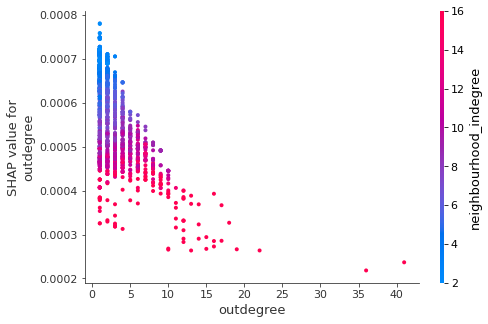

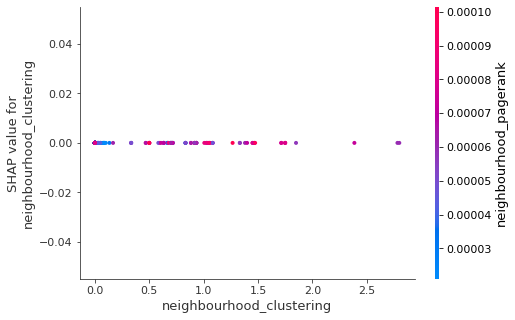

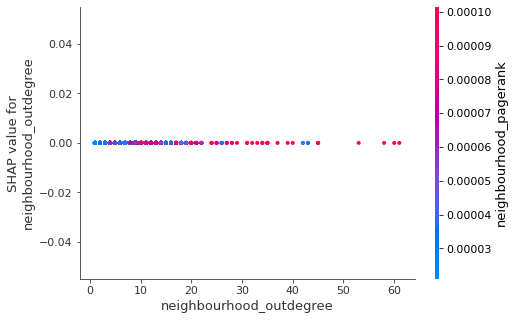

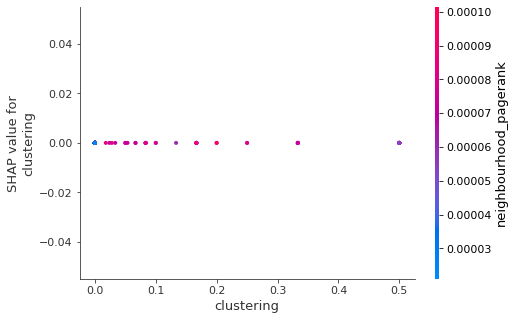

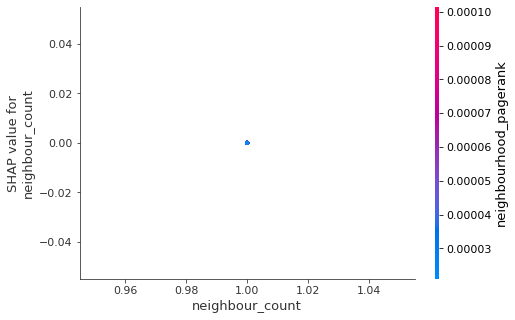

In [30]:
for i in range(1, X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()